In [6]:
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow import keras
from PIL import Image
import PIL

In [2]:
path_img = r'/home/tm/satellite_mini/ds/images/'
path_mask = r'/home/tm/satellite_mini/ds/masks/'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
      path_img,
      shuffle=False,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(256, 256),
      batch_size=16,
      color_mode="rgb",
      labels=None,
       )

Found 2841 files belonging to 1 classes.
Using 2273 files for training.


2023-02-20 13:11:44.684511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 13:11:44.734490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 13:11:44.734650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-20 13:11:44.739781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
      path_img,
      shuffle=False,
      validation_split=0.2,
      subset="validation",
      seed=123,
      image_size=(256, 256),
      batch_size=16,
      color_mode="rgb",
      labels=None,
       )

Found 2841 files belonging to 1 classes.
Using 568 files for validation.


In [5]:
train_mask = tf.keras.utils.image_dataset_from_directory(
      path_mask,
      shuffle = False,
      validation_split=0.2,
      image_size=(256, 256),
      subset="training",
      batch_size=16,
      color_mode="grayscale" , 
      labels = None)
train_mask = train_mask.map(lambda x:(x/255.0))


Found 2841 files belonging to 1 classes.
Using 2273 files for training.


In [6]:
val_mask = tf.keras.utils.image_dataset_from_directory(
      path_mask,
      shuffle = False,
      validation_split=0.2,
      image_size=(256, 256),
      subset="validation",
      batch_size=16,
      color_mode="grayscale" , 
      labels = None)
val_mask = val_mask.map(lambda x:(x/255.0))

Found 2841 files belonging to 1 classes.
Using 568 files for validation.


In [7]:
train_ds.element_spec

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)

In [22]:
IMG_HEIGHT=256
IMG_WIDTH = 256
IMG_CHANNELS=3
def unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    norm = tf.keras.layers.Lambda(lambda x : x/255)(inputs)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(norm)
    c1 = tf.keras.layers.Dropout(0.2)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.2)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.4)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.4)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.5)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.4)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.4)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='BinaryCrossentropy', metrics=['accuracy'])
#     model.summary()
    return model

In [19]:
model = unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
dataset = tf.data.Dataset.zip((train_ds,train_mask))
history = model.fit(dataset,  epochs=12)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)   

In [7]:
model = tf.keras.models.load_model("model_0.75/")
# model2.summary()

In [10]:
test_ds=[]
i=0
for element in val_ds:
    if i>6:
        break
    for image in element:
        test_ds.append(image)
    i=i+1
test_ds = np.array(test_ds)
results = model.predict(test_ds)
# validation = tf.data.Dataset.zip((val_ds,val_mask))
# evaluation = model.evaluate(validation)

4/4 [==============================] - 3s 957ms/step


In [11]:
# print(img)
input_pic=[]
i=0
for element in val_ds:
    if i>6:
        break
    for image in element:
        input_pic.append(image)
    i=i+1
input_pic = np.array(input_pic)
print(input_pic.shape)


(112, 256, 256, 3)


In [24]:
index = 22

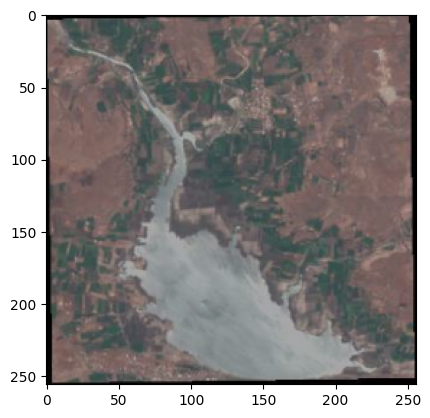

In [25]:
input_image=input_pic[index]
input_image=input_image/255.0
plt.imshow(input_image)
plt.show()

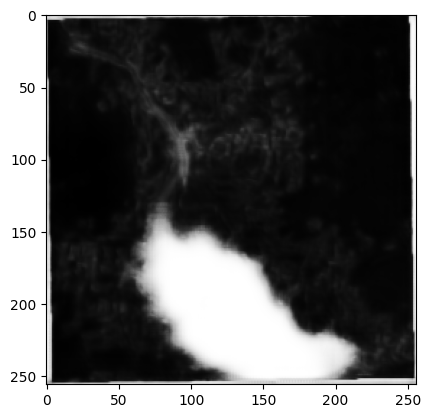

In [26]:
img = results[index]
# img = img*255
plt.imshow(img,cmap = 'gray')
plt.show()


In [20]:
model.save("model_0.67")

INFO:tensorflow:Assets written to: model_0.67/assets


INFO:tensorflow:Assets written to: model_0.67/assets
